<a href="https://colab.research.google.com/github/Tommy840602/NLP/blob/main/relation_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')
from spacy.matcher import Matcher
from spacy.tokens import Span
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [2]:
candidate_sentences = pd.read_csv("/content/wiki_sentences_v2.csv")
candidate_sentences.shape

(4318, 1)

In [3]:
candidate_sentences['sentence'].sample(5)

986     in budapest, special effects supervisor neil corbould created the film's largest set piece:
578                                                his cgi scenes received better notices, as well.
1489                                                            meitei cinema started in the 1980s.
2760                                              other film directors have attended a film school.
451                              the venice film festival is the oldest film festival in the world.
Name: sentence, dtype: object

In [4]:
#Sentence Segmentation
doc = nlp("the drawdown process is governed by astm standard d823")
for tok in doc:
  print(tok.text, "...", tok.dep_)

the ... det
drawdown ... amod
process ... nsubjpass
is ... auxpass
governed ... ROOT
by ... agent
astm ... compound
standard ... compound
d823 ... pobj


In [5]:
#Entities Extraction
def get_entities(sent):
  ent1 = ""
  ent2 = ""
  prv_tok_dep = ""
  prv_tok_text = ""
  prefix = ""
  modifier = ""

  for tok in nlp(sent):
    if tok.dep_ != "punct":
      if tok.dep_ == "compound":
        prefix = tok.text
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text

      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text

      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""

      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text

      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text

  return [ent1.strip(), ent2.strip()]

In [6]:
get_entities("the film had 200 patents")

['film', '200  patents']

In [7]:
entity_pairs = []
for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 4318/4318 [00:39<00:00, 108.56it/s]


In [8]:
entity_pairs[10:20]

[['we', 'tests'],
 ['m', 'international sales rights'],
 ['canadian musician robbie robertson', 'soundtrack'],
 ['it', 'original music tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'accidentally  mystique'],
 ['military  forces', 'arrest'],
 ['train', 'vuk'],
 ['kota eberhardt', 'telepath selene gallio'],
 ['singer', 'men']]

In [21]:
# Relations Extraction
def get_relation(sent):
  doc = nlp(sent)
  matcher = Matcher(nlp.vocab)
  pattern = [{'DEP':'ROOT'},
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},
            {'POS':'ADJ','OP':"?"}]
  matcher.add("matching_1", [pattern], on_match=None)
  matches = matcher(doc)
  k = len(matches) -1
  span = doc[matches[k][1]:matches[k][2]]
  return(span.text)

In [22]:
get_relation("John completed the task")

'completed'

In [23]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]

100%|██████████| 4318/4318 [00:44<00:00, 97.57it/s] 


In [24]:
pd.Series(relations).value_counts()[:50]

is               364
was              308
released on       90
are               74
include           73
were              68
released          41
's                39
composed by       34
became            31
have              31
has               30
become            28
released in       27
included          23
had               21
produced          21
been              20
called            19
used              19
considered        18
made              18
scheduled         17
be                17
directed by       16
stars             16
hired             14
produced by       14
written by        13
wrote             13
received          13
introduced in     13
went              13
wanted            12
sold              12
began in          11
set               11
began             11
cast as           11
won               11
gave              10
directed          10
includes          10
gives              9
going              9
produced in        9
opened             9
features     

In [25]:
#Build Knowledge Graph
source = [i[0] for i in entity_pairs]
target = [i[1] for i in entity_pairs]
kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [26]:
G=nx.from_pandas_edgelist(kg_df, "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())

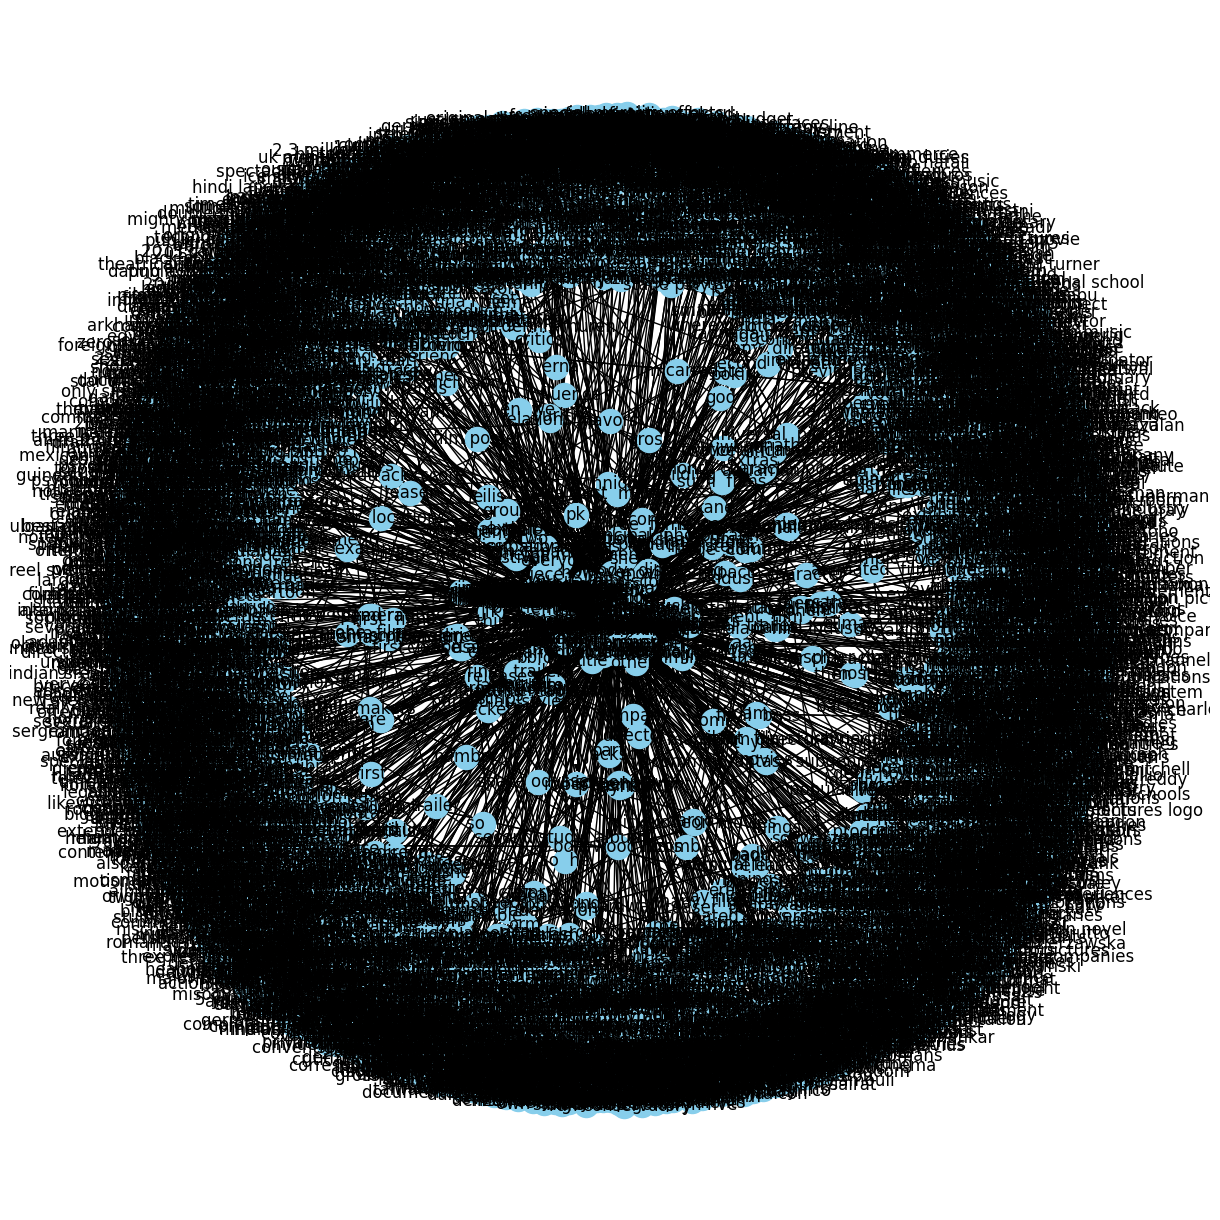

In [27]:
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

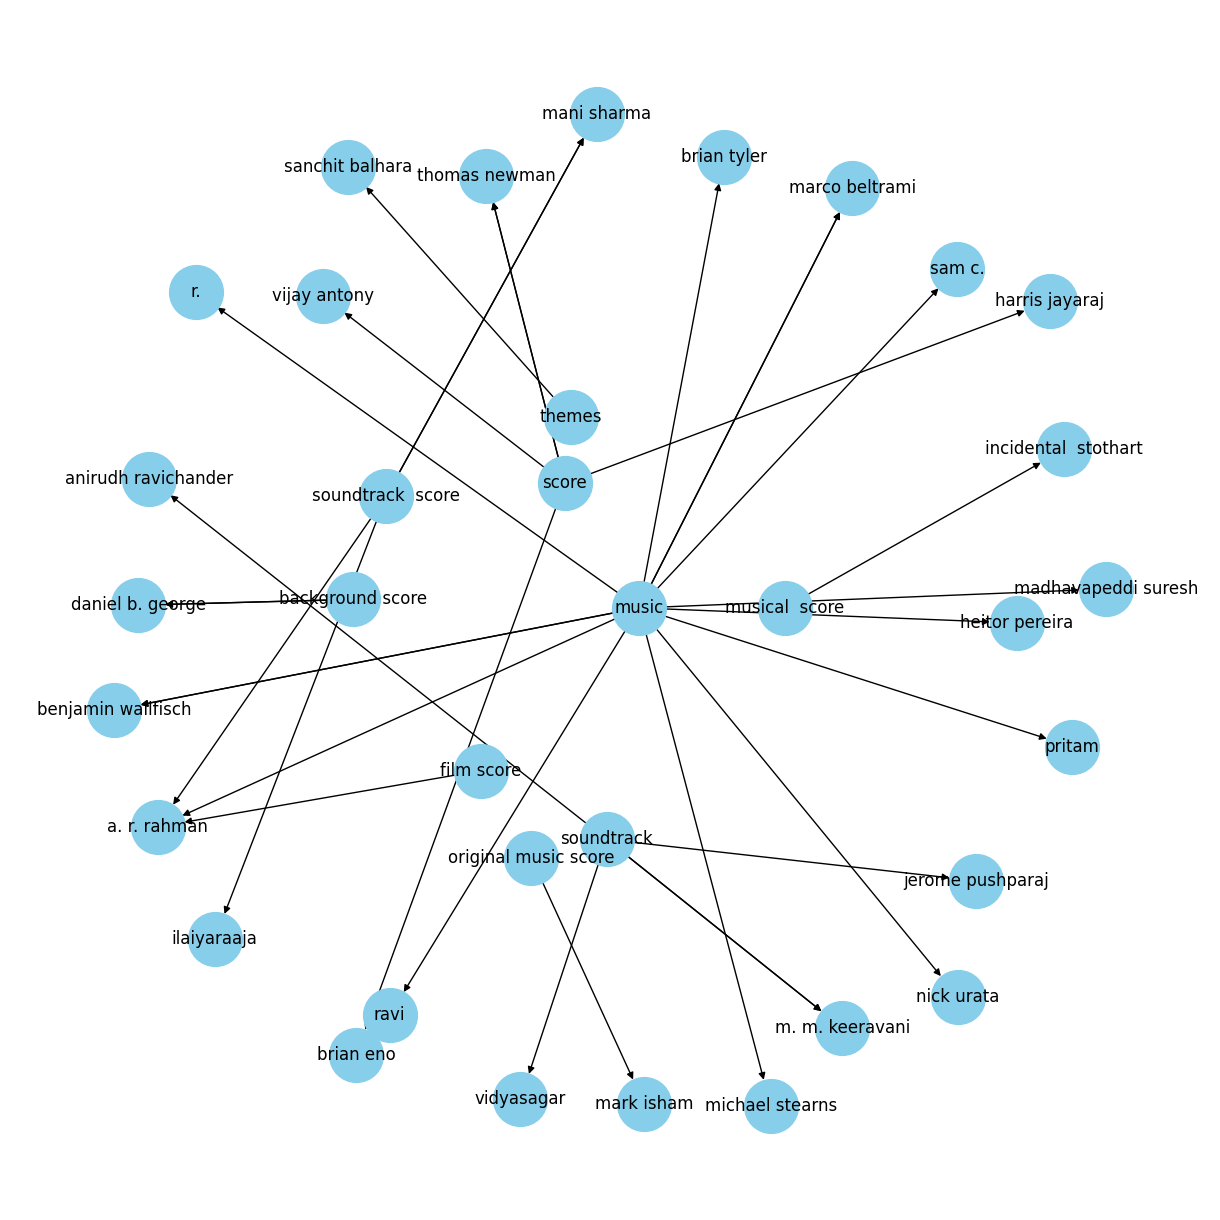

In [28]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

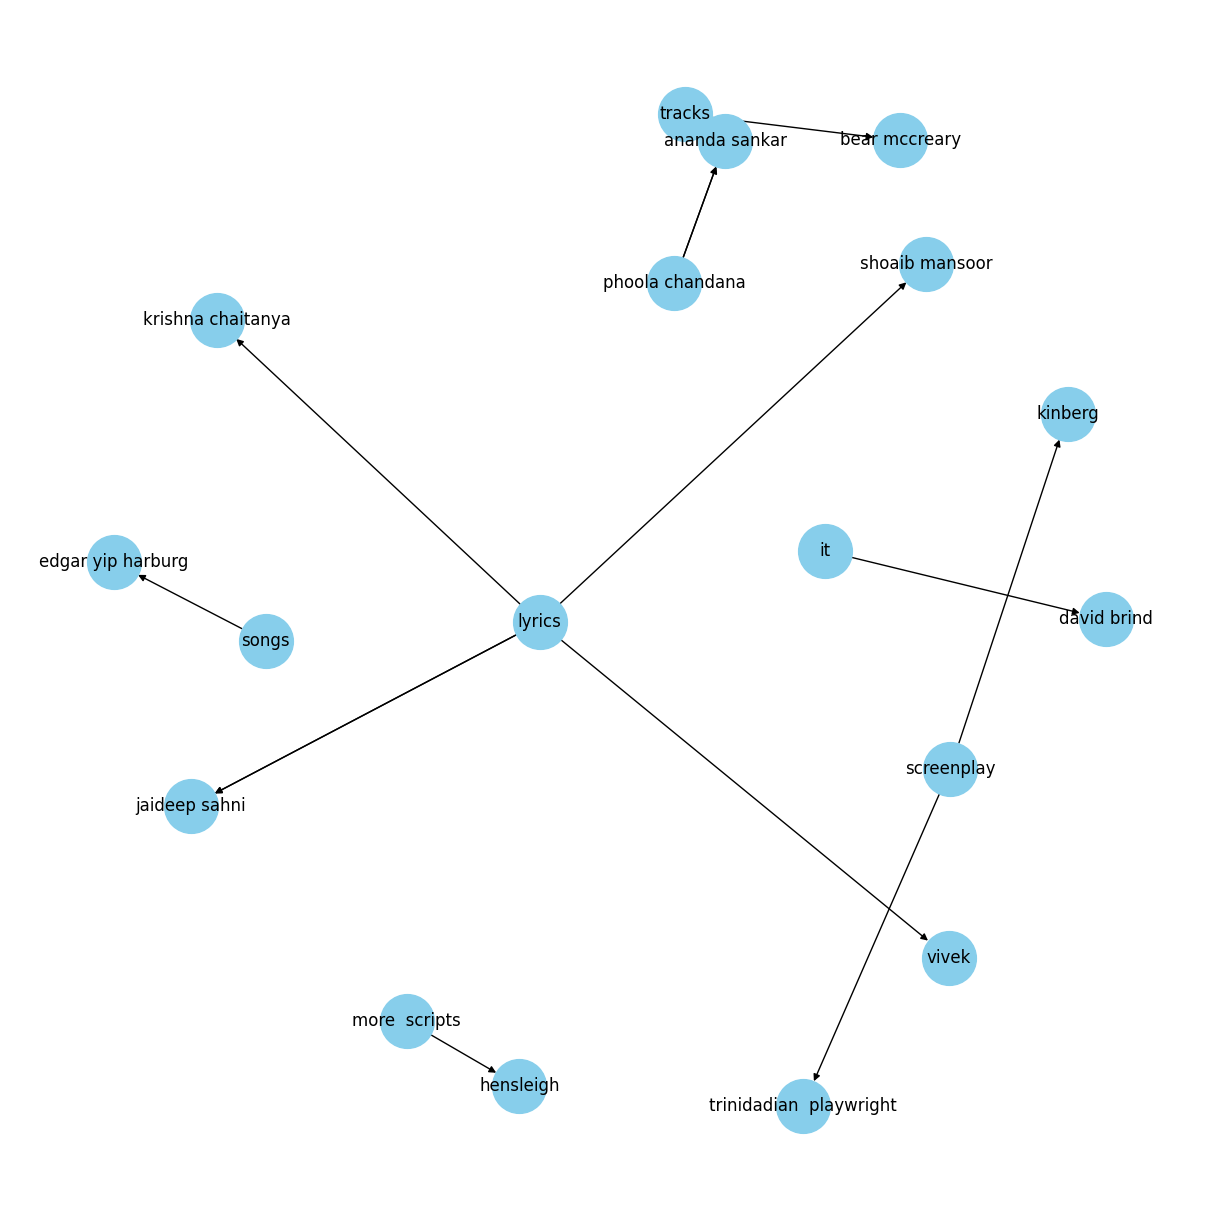

In [29]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="written by"], "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

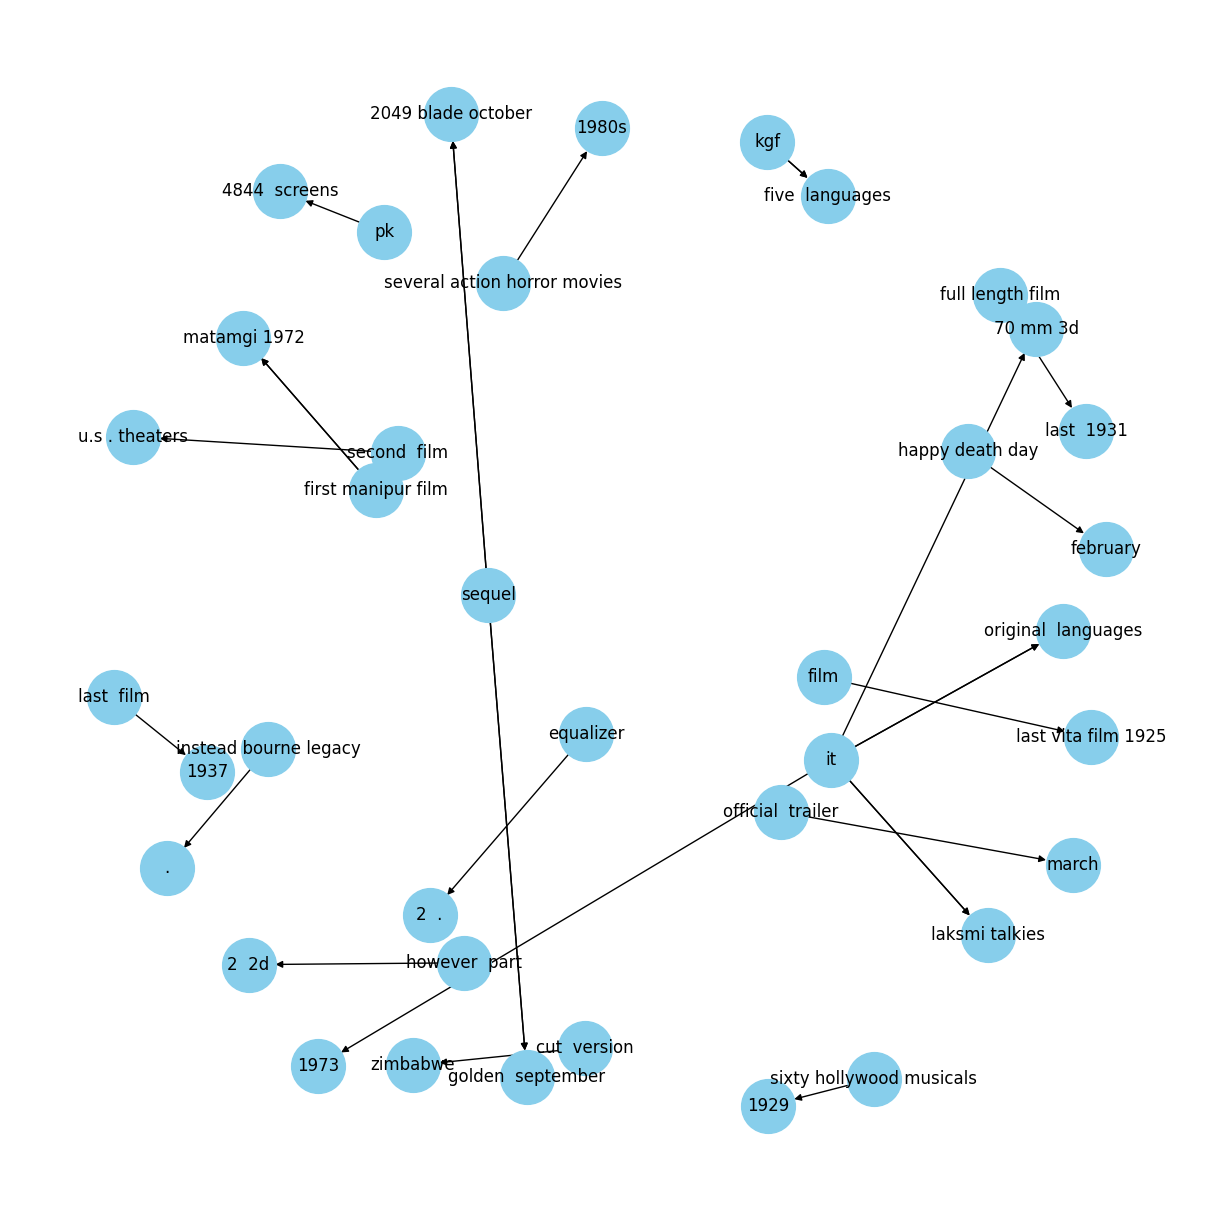

In [30]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released in"], "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()